In [1]:
import anndata
import numpy as np
import sys
import torch
import scvelo as scv
sys.path.append('../../../../')
import velovae as vv

In [2]:
dataset = 'Erythroid'
#adata = scv.datasets.gastrulation_erythroid()
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')
#standardize the cluster key
adata.obs["clusters"] = adata.obs["celltype"].to_numpy()

In [ ]:
# vv.preprocess(adata, n_gene=2000, min_shared_counts=20)

In [3]:
model_path_base = f'{root}/checkpoints/{dataset}_notime'
figure_path_base = f'{root}/figures/{dataset}_notime'
data_path = f'{root}/data/velovae/continuous/{dataset}_notime'
gene_plot = ['Smim1', 'Blvrb', 'Hba-x', 'Lmo2']

# Informative Time Prior

In [4]:
capture_time = adata.obs['stage'].to_numpy()
tprior = np.array([float(x[1:]) for x in capture_time])
adata.obs['tprior'] = tprior

# VeloVAE

In [5]:
figure_path = f'{figure_path_base}/VeloVAE'
model_path = f'{model_path_base}/VeloVAE'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0',
             init_method='tprior',
             init_key='tprior',
             tprior=None,
             init_ton_zero=False)


vae.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'velovae', data_path, file_name=f'{dataset}.h5ad')

Estimating ODE parameters...


  0%|          | 0/1000 [00:00<?, ?it/s]

Detected 211 velocity genes.
Estimating the variance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Initialization using prior time.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/1000 [00:00<?, ?it/s]

Initial induction: 126, repression: 874/1000
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 54, test iteration: 106
*********       Stage 1: Early Stop Triggered at epoch 260.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/9815 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.029
Average Set Size: 197
*********     Round 1: Early Stop Triggered at epoch 482.    *********
Change in noise variance: 0.9364
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 516.    *********
Change in noise variance: 0.0053
Change in x0: 0.4191
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 573.    *********
Change in noise variance: 0.0003
Change in x0: 0.2934
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 587.    *********
Change in noise variance: 0.0000
Change in x0: 0.3921
*********             Velocity Refinement Round 5             *********
Stage 2: Early Stop Triggered at round 4.
*********              Finished. Total Time =   0 h :  9 m : 58 s             *********
Final: Train ELBO = 2623.214,	Test ELBO = 2603.

# FullVB

In [11]:
figure_path = f'{figure_path_base}/FullVB'
model_path = f'{model_path_base}/FullVB'

torch.manual_seed(2022)
np.random.seed(2022)

full_vb = vv.VAE(adata, 
                 tmax=20, 
                 dim_z=5, 
                 device='cuda:0',
                 full_vb=True,
                 init_method='tprior',
                 init_key='tprior',
                 tprior=None,
                 init_ton_zero=False)

full_vb.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

full_vb.save_model(model_path, 'encoder', 'decoder')
full_vb.save_anndata(adata, 'fullvb', data_path, file_name=f'{dataset}.h5ad')

Estimating ODE parameters...


  0%|          | 0/1000 [00:00<?, ?it/s]

Detected 211 velocity genes.
Estimating the variance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Initialization using prior time.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/1000 [00:00<?, ?it/s]

Initial induction: 126, repression: 874/1000
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 54, test iteration: 106
*********       Stage 1: Early Stop Triggered at epoch 342.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/9815 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 197
*********     Round 1: Early Stop Triggered at epoch 586.    *********
Change in noise variance: 0.8985
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 665.    *********
Change in noise variance: 0.0048
Change in x0: 1.1409
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 773.    *********
Change in noise variance: 0.0007
Change in x0: 0.5067
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 834.    *********
Change in noise variance: 0.0000
Change in x0: 0.4252
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 846.    *********
Change in noise variance: 0.0000
Change in x0: 0.4053
*********             Velocity Refinement Round 6   

# Evaluation

computing velocity graph (using 1/32 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)


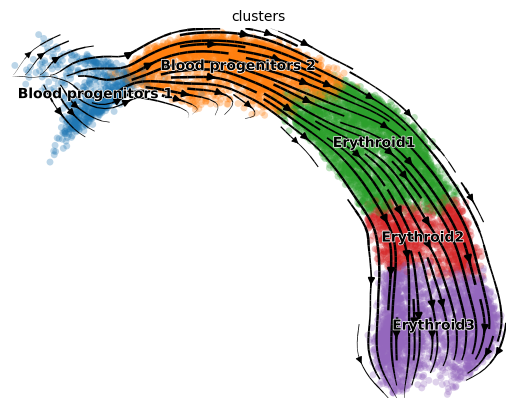

In [13]:
vel_genes = np.load('/scratch/blaauw_root/blaauw1/gyichen/perf/Erythroid_scv_vel_genes.npy')
adata.var['velocity_genes'] = vel_genes
scv.tl.velocity_graph(adata, vkey='fullvb_velocity', gene_subset=adata.var_names[vel_genes])
scv.pl.velocity_embedding_stream(adata, vkey='fullvb_velocity')

---   Plotting  Results   ---


(None, None)

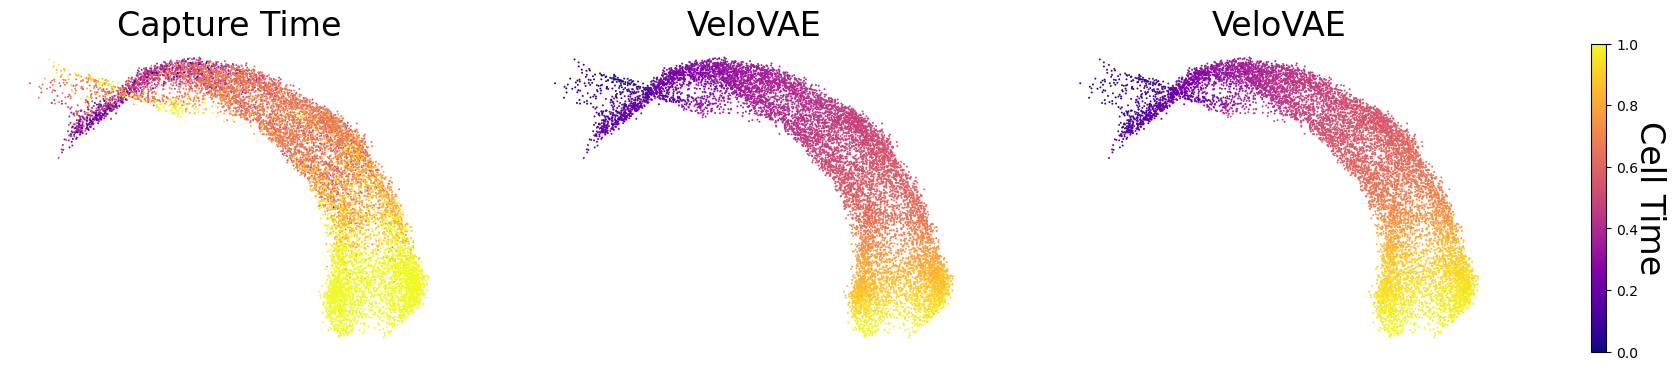

In [14]:
vv.post_analysis(adata,
                 'eval',
                 ['VeloVAE', 'FullVB'],
                 ['velovae', 'fullvb'],
                 compute_metrics=False,
                 genes=gene_plot,
                 plot_type=['time'],
                 grid_size=(1,4),
                 figure_path=None)